In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX2X97W/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX2X97W/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX2X97W/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# learning rate
learning_rate = 0.001

# optimizers
optimizer = tf.keras.optimizers.Adam(learning_rate) # adam
# optimizer = tf.keras.optimizers.RMSprom(learning_rate) # rms prop

In [7]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [8]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 780s 2s/step - loss: 0.4932 - accuracy: 0.7432 - val_loss: 0.3889 - val_accuracy: 0.8281
Epoch 2/10
391/391 [==============================] - 743s 2s/step - loss: 0.3690 - accuracy: 0.8407 - val_loss: 0.3752 - val_accuracy: 0.8313
Epoch 3/10
391/391 [==============================] - 766s 2s/step - loss: 0.3440 - accuracy: 0.8495 - val_loss: 0.3762 - val_accuracy: 0.8094
Epoch 4/10
391/391 [==============================] - 733s 2s/step - loss: 0.3264 - accuracy: 0.8593 - val_loss: 0.3374 - val_accuracy: 0.8448
Epoch 5/10
391/391 [==============================] - 753s 2s/step - loss: 0.3110 - accuracy: 0.8655 - val_loss: 0.3656 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 753s 2s/step - loss: 0.3033 - accuracy: 0.8704 - val_loss: 0.3998 - val_accuracy: 0.8188
Epoch 7/10
391/391 [==============================] - 758s 2s/step - loss: 0.2928 - accuracy: 0.8738 - val_loss: 0.3433 - val_accuracy: 0.8479

In [12]:
history.history

{'loss': [0.4931967556476593,
  0.3689972758293152,
  0.3440026044845581,
  0.32643625140190125,
  0.31096401810646057,
  0.3033260107040405,
  0.2928265929222107,
  0.2895898222923279,
  0.3001909852027893,
  0.2625426948070526],
 'accuracy': [0.7431600093841553,
  0.840719997882843,
  0.8495200276374817,
  0.859279990196228,
  0.8654800057411194,
  0.8704000115394592,
  0.8737599849700928,
  0.8769199848175049,
  0.870639979839325,
  0.8888800144195557],
 'val_loss': [0.38887736201286316,
  0.37524640560150146,
  0.37622636556625366,
  0.3373768925666809,
  0.3656146824359894,
  0.3998470604419708,
  0.3433127999305725,
  0.3432309329509735,
  0.36727315187454224,
  0.360863596200943],
 'val_accuracy': [0.828125,
  0.831250011920929,
  0.809374988079071,
  0.8447916507720947,
  0.84375,
  0.8187500238418579,
  0.8479166626930237,
  0.8411458134651184,
  0.8182291388511658,
  0.8458333611488342]}

(0.0, 0.5047294586896897)

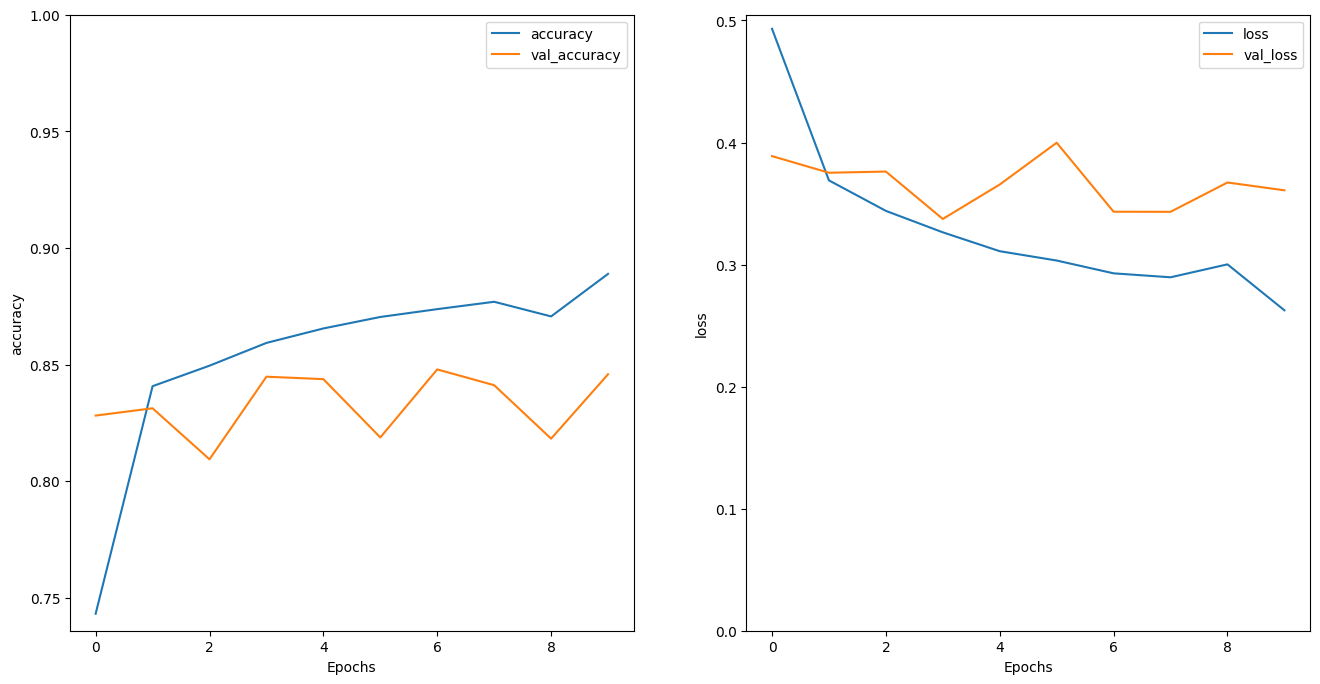

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [11]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 183s 467ms/step - loss: 0.3499 - accuracy: 0.8564
Test Loss: 0.34985265135765076
Test Accuracy: 0.8564000129699707
